# Plotting Exercises, Part 2

<span style="color: #008080">*Jiechen Li*</span>


## Wealth and Democracy

Let's now pivot from working with example data to real data. Load the World Development Indicator data you worked with over the summer. This is country-level data that includes information on both countries' GDP per capita (a measure of wealth) and the Polity IV scores (a measure of how democratic a country is -- countries with higher scores are liberal democracies, countries with low scores are autocratic.). Use the code below to download the data. 

In [100]:
import pandas as pd
import numpy as np

pd.set_option("mode.copy_on_write", True)

wdi = pd.read_csv(
    "https://raw.githubusercontent.com/nickeubank/"
    "practicaldatascience/master/Example_Data/world-small.csv"
)

Your data should look like this: 

In [101]:
wdi.head()

,country,region,gdppcap08,polityIV
0,Albania,C&E Europe,7715,17.8
1,Algeria,Africa,8033,10.0
2,Angola,Africa,5899,8.0
3,Argentina,S. America,14333,18.0
4,Armenia,C&E Europe,6070,15.0


### Exercise 1

Let's being analyzing this data by estimating a simple linear model ("ordinary least squares") of the relationship between GDP per capita (`gdppcap08`) and democracy scores (`polityIV`). We will do so using the `statsmodel` package, which we'll discuss in detail later is this course. For the momement, just use this code:

```python
import statsmodels.formula.api as smf
results = smf.ols('polityIV ~ gdppcap08',
                   data=wdi).fit()
print(results.summary())
```


In [102]:
import statsmodels.formula.api as smf

results = smf.ols("polityIV ~ gdppcap08", data=wdi).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               polityIV   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     6.981
Date:                Wed, 25 Oct 2023   Prob (F-statistic):            0.00915
Time:                        19:55:48   Log-Likelihood:                -475.14
No. Observations:                 145   AIC:                             954.3
Df Residuals:                     143   BIC:                             960.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.1354      0.721     16.841      0.0

### Exercise 2

Based on the results of this analysis, what would you conclude about about the relationship between `gdppcap08` and `polityIV`? 

(If you aren't familiar with Linear Models and aren't sure how to interprete this, you can also just look at the simple correlation between these two variables using `wdi[['polityIV', 'gdppcap08']].corr()`.)

Write down your conclusions. 

In [103]:
IV_08_wdi = wdi[["polityIV", "gdppcap08"]].corr()
IV_08_wdi

,polityIV,gdppcap08
polityIV,1.000000,0.215749
gdppcap08,0.215749,1.000000


<span style="color: #008080">``gdppcap08``'s p-value is 0.009, which is less than the conventional significance level of 0.05. This indicates that there's a statistically significant relationship between ``gdppcap08`` and ``polityIV``. There's a statistically significant positive relationship between GDP per capita (``gdppcap08``) and democracy scores (``polityIV``).</span>

### Exercise 3

Now let's plot the relationship you just estimated statistically. First, use seaborn to create a scatter plot of `polityIV` and `gdppcap08`. Include a title and label your axes (with formatted words, not variable names).

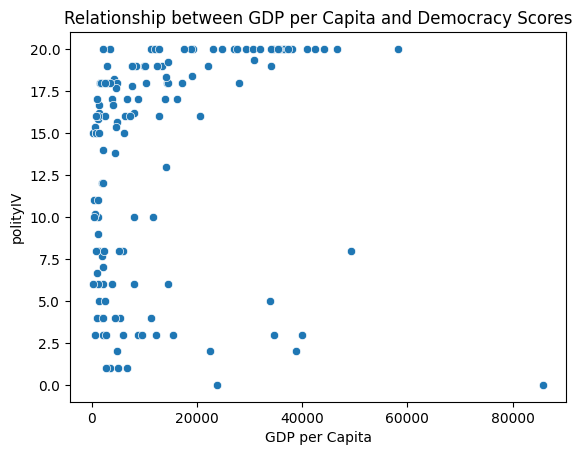

In [104]:
import seaborn as sns

plot = sns.scatterplot(data=wdi, x="gdppcap08", y="polityIV")
plot.set_title("Relationship between GDP per Capita and Democracy Scores")
plot.set_xlabel("GDP per Capita")
plot.set_label("Democracy Scores")

### Exercise 4

Now add a linear regression (*not* a higher order polynomial, just linear) fit to the scatter plot.

Text(0, 0.5, 'Democracy Scores')

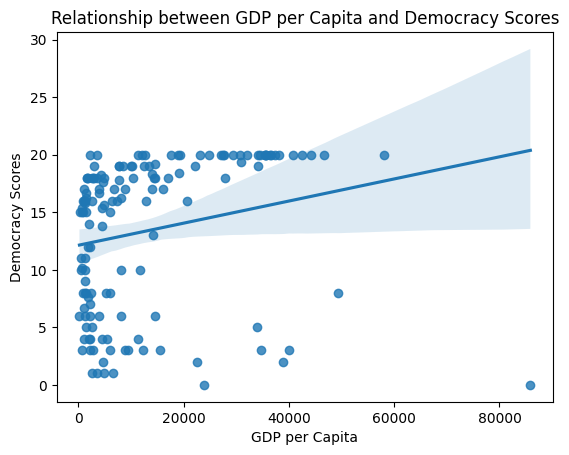

In [105]:
plot_rg = sns.regplot(data=wdi, x="gdppcap08", y="polityIV")
plot_rg.set_title("Relationship between GDP per Capita and Democracy Scores")
plot_rg.set_xlabel("GDP per Capita")
plot_rg.set_ylabel("Democracy Scores")

### Exercise 5

Does it seem like the linear model you estimated fits the data well?

<span style="color: #008080">Considering the low R-squared and the visual inspection of the scatter plot, it seems the linear model does not fit the data particularly well. While there is a statistically significant relationship, the linear model might be too simplistic to capture the underlying relationship between GDP per capita and democracy scores. Other factors not included in this model might also influence democracy scores, or there might be non-linear relationships at play.</span>

### Exercise 6

Linear models impose a very strict functional form on the model they use: they try to draw a straight line through the data, no matter what. 

Can you think of a transform for your data that would make the data a little more sane?

Apply the transformation.

<span style="color: #008080">Based on my linear regression knowledge and real-world consideration of dealing with GDP , I will try log transformation to help GDP linearize exponential growth. Taking the log transformation of GDP per capita might spread out countries that are clustered at the lower end and compress countries at the higher end, potentially revealing a more linear relationship.</span>

In [106]:
# log transformation
wdi_log = wdi.copy()
wdi_log["log_gdppcap08"] = np.log(wdi_log["gdppcap08"])

Text(0, 0.5, 'Democracy Scores')

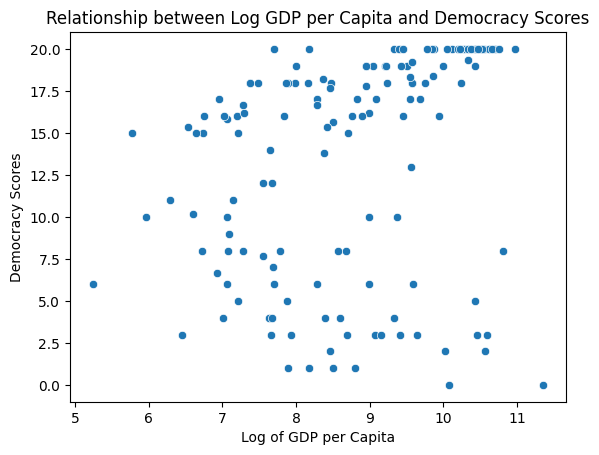

In [107]:
# plot log
plot_log = sns.scatterplot(data=wdi_log, x="log_gdppcap08", y="polityIV")
plot_log.set_title("Relationship between Log GDP per Capita and Democracy Scores")
plot_log.set_xlabel("Log of GDP per Capita")
plot_log.set_ylabel("Democracy Scores")

### Exercise 7

Once you've applied that transformation, let's re-fit our model. 

Rather than imposing linearity this time, however, let's fit a model with a flexible functional form. Using the recipe for a [lowess regression you can find here](https://nickeubank.github.io/practicaldatascience_book/notebooks/class_5/week_2/20_plotting_with_seaborn.html#a-little-bonus), see how well a lowess regression fits your updated data. This is a form of local polynomial regression that is designed to be flexible in how it fits the data. 

In [108]:
from dataclasses import dataclass
from seaborn._stats.base import Stat
import statsmodels.api as sm


@dataclass
class Lowess(Stat):
    """
    Fit a locally-weighted regression to smooth the data.
    """

    frac: float = 0.2  # Fraction of data to use when estimating each y-value
    gridsize: int = 100  # How fine-grained to plot the curve. Increase if jagged.

    def _fit_predict(self, data):
        x = data["x"]
        xx = np.linspace(x.min(), x.max(), self.gridsize)
        # https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html
        yy = sm.nonparametric.lowess(exog=x, endog=data["y"], xvals=xx, frac=self.frac)
        return pd.DataFrame(dict(x=xx, y=yy))

    def __call__(self, data, groupby, orient, scales):
        return groupby.apply(data.dropna(subset=["x", "y"]), self._fit_predict)

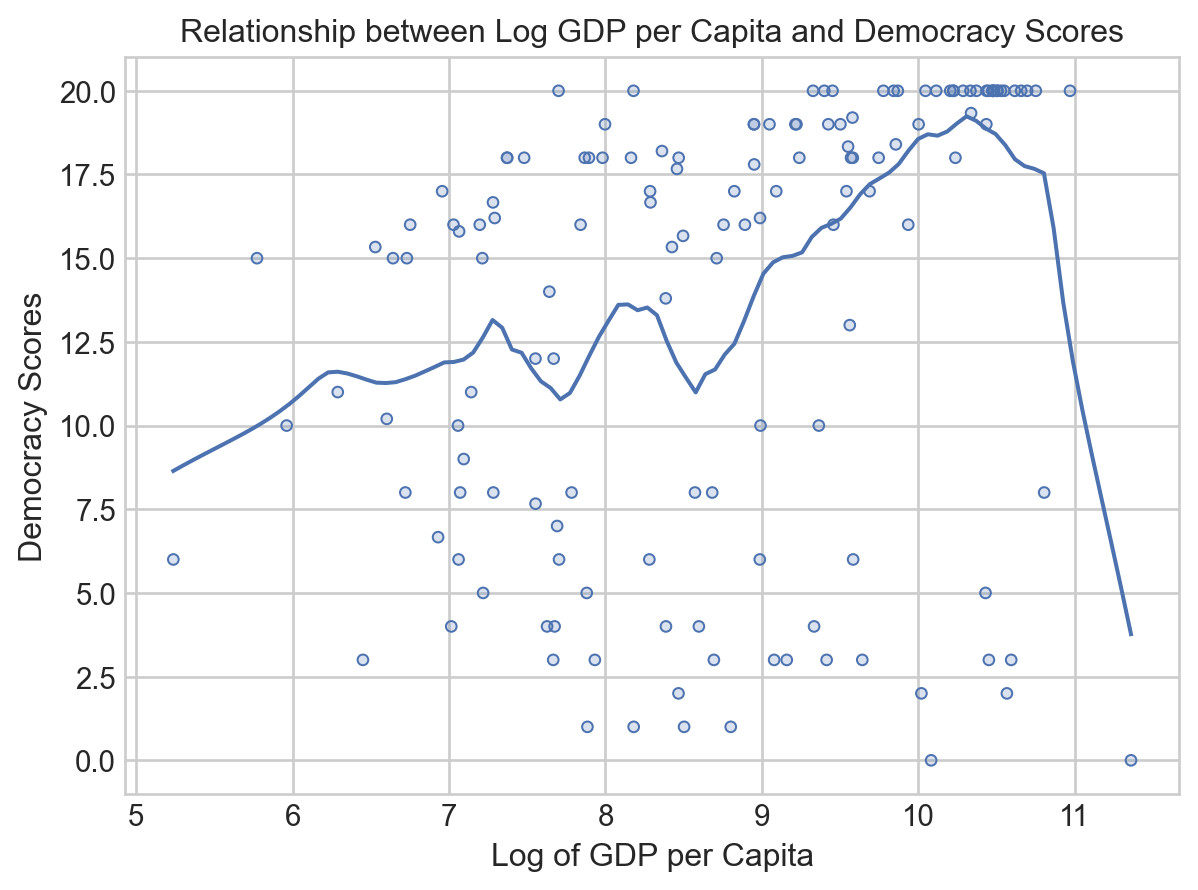

In [109]:
import seaborn.objects as so
from matplotlib import style

(
    so.Plot(wdi_log, x="log_gdppcap08", y="polityIV")
    .add(so.Dots())
    .add(so.Lines(), Lowess())
    .label(
        x="Log of GDP per Capita",
        y="Democracy Scores",
        title="Relationship between Log GDP per Capita and Democracy Scores",
    )
    .theme({**style.library["seaborn-v0_8-whitegrid"]})
)

### Exercise 8

This does seem to fit the data better, but there seem to be quite a few outliers in the bottom right. Who is that? Add text labels to the points on your graph with country names. Make sure the size of your text labels leaves them legible.

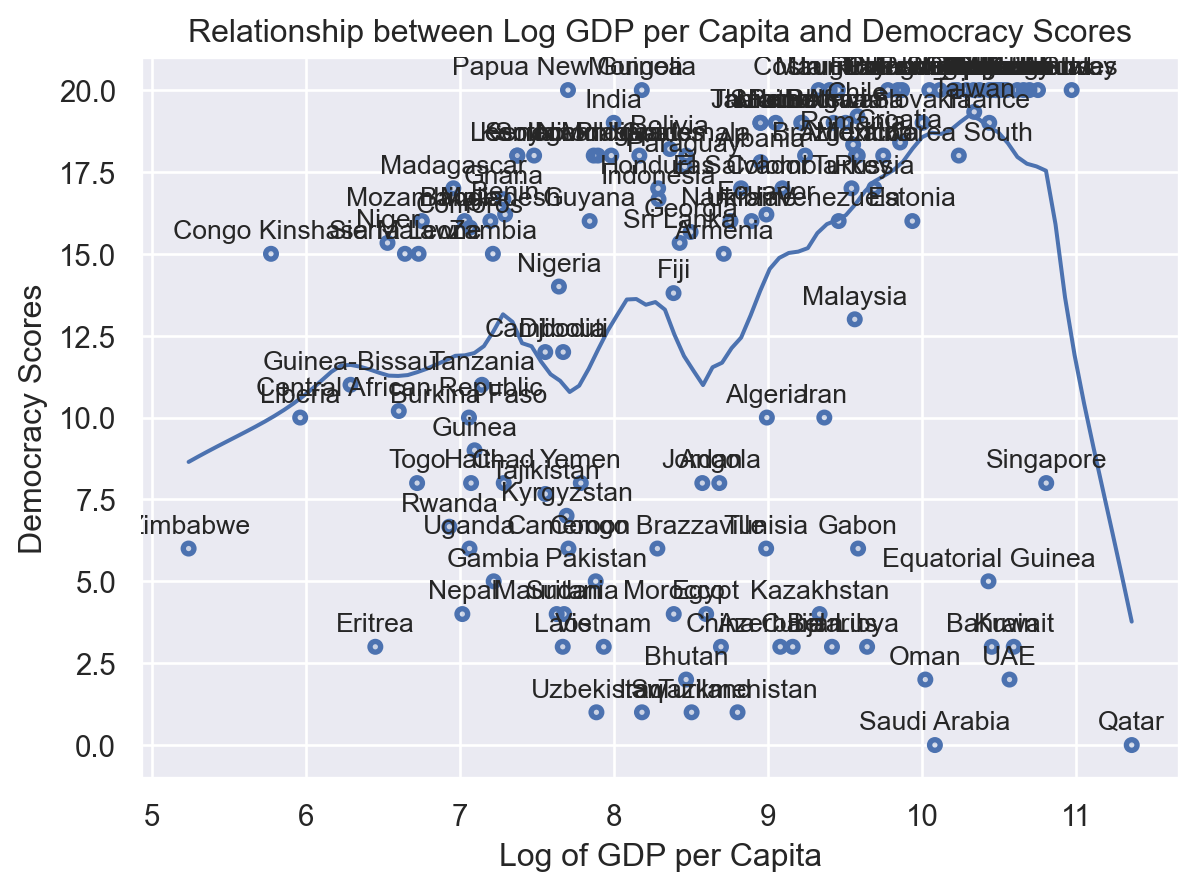

In [110]:
import seaborn.objects as so
from matplotlib import style

updated_theme = style.library["seaborn-v0_8-whitegrid"] | {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.grid": False,
}


(
    so.Plot(wdi_log, x="log_gdppcap08", y="polityIV")
    .add(so.Dots(stroke=2))
    .add(so.Line(), Lowess())
    .add(so.Text(fontsize=10, valign="bottom"), text="country")
    .label(
        x="Log of GDP per Capita",
        y="Democracy Scores",
        title="Relationship between Log GDP per Capita and Democracy Scores",
    )
    # .theme({**updated_theme})
)

### Exercise 9

Interesting. It seems that there's are a lot of rich, undemocratic countries that all have something in common: they're oil-rich, small, Middle Eastern countries.

Let's see what happens if we exclude the ten countries with the highest per-capita oil production from our data: Qatar, Kuwait, Equatorial Guinea, United Arab Emirates, Norway, Saudi Arabia, Libya, Oman, Gabon, and Angola. (Note this was in 2007, and excludes very small countries!) 

What does the relationship between Polity and GDP per capita look like for non-natural resource producers?

In [111]:
# oil_rich_countries
oil_rich_countries = [
    "Qatar",
    "Kuwait",
    "Equatorial Guinea",
    "UAE",
    "Norway",
    "Saudi Arabia",
    "Libya",
    "Oman",
    "Gabon",
    "Angola",
]

# filter out oil rich countries from wdi_log_sample
wdi_filtered_sample = wdi_log[~wdi_log["country"].isin(oil_rich_countries)]
wdi_filtered_sample.sample()

,country,region,gdppcap08,polityIV,log_gdppcap08
76,Liberia,Africa,388,10.0,5.961005


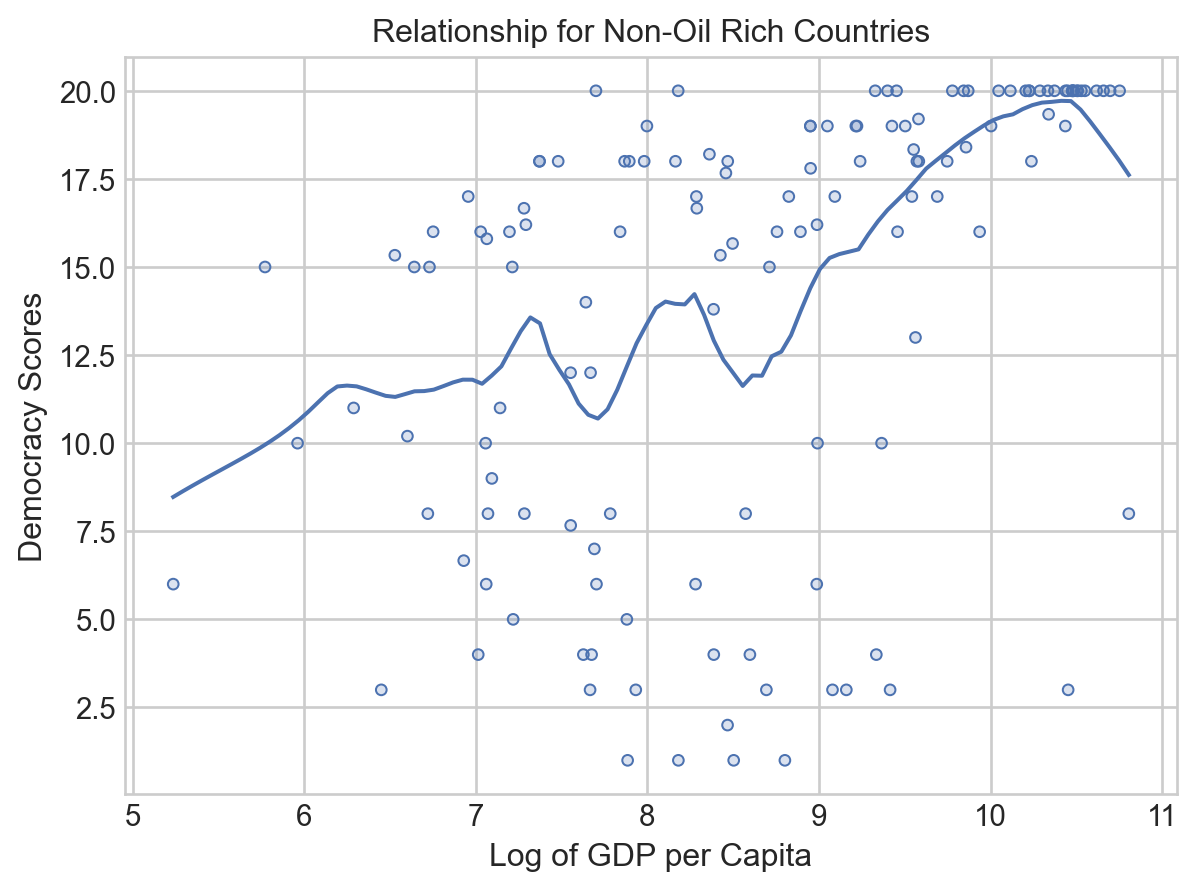

In [112]:
# plot without oil_rich_countries
# change the code as 7 do the regression line


@dataclass
class Lowess(Stat):
    """
    Fit a locally-weighted regression to smooth the data.
    """

    frac: float = 0.2  # Fraction of data to use when estimating each y-value
    gridsize: int = 100  # How fine-grained to plot the curve. Increase if jagged.

    def _fit_predict(self, data):
        x = data["x"]
        xx = np.linspace(x.min(), x.max(), self.gridsize)
        # https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html
        yy = sm.nonparametric.lowess(exog=x, endog=data["y"], xvals=xx, frac=self.frac)
        return pd.DataFrame(dict(x=xx, y=yy))

    def __call__(self, data, groupby, orient, scales):
        return groupby.apply(data.dropna(subset=["x", "y"]), self._fit_predict)


(
    so.Plot(wdi_filtered_sample, x="log_gdppcap08", y="polityIV")
    .add(so.Dots())
    .add(so.Lines(), Lowess())
    .label(
        x="Log of GDP per Capita",
        y="Democracy Scores",
        title="Relationship for Non-Oil Rich Countries",
    )
    .theme({**style.library["seaborn-v0_8-whitegrid"]})
)

### Exercise 10

Let's make sure that you accurately identified all 10 of the oil producers. Write a line of code to count up how many big producers you have identified. If you do not get 10, can you figure out what you did wrong?

In [113]:
num_oil_producers = wdi[wdi["country"].isin(oil_rich_countries)].shape[0]
print(num_oil_producers)

10


In [114]:
missing_countries = [
    country for country in oil_rich_countries if country not in wdi["country"].tolist()
]
print(missing_countries)

[]


In [115]:
uae_variants = wdi[wdi["country"].str.contains("United Arab", case=False, na=False)]
print(uae_variants["country"])

Series([], Name: country, dtype: object)


<span style="color: #008080">I missed "United Arab Emirates" so I had removed nine contries instead of 10. From the plot, I noticed that UAE is used in the dataset instead of United Arab Emirates. I changed the name and will remove UAE for the country of United Arab Emirates.</span>

### Exercise 11

How does the relationship between GDP per capita and Polity look for the oil producers we dropped above?

(note a Lowess line may not plot if you don't have enough data)

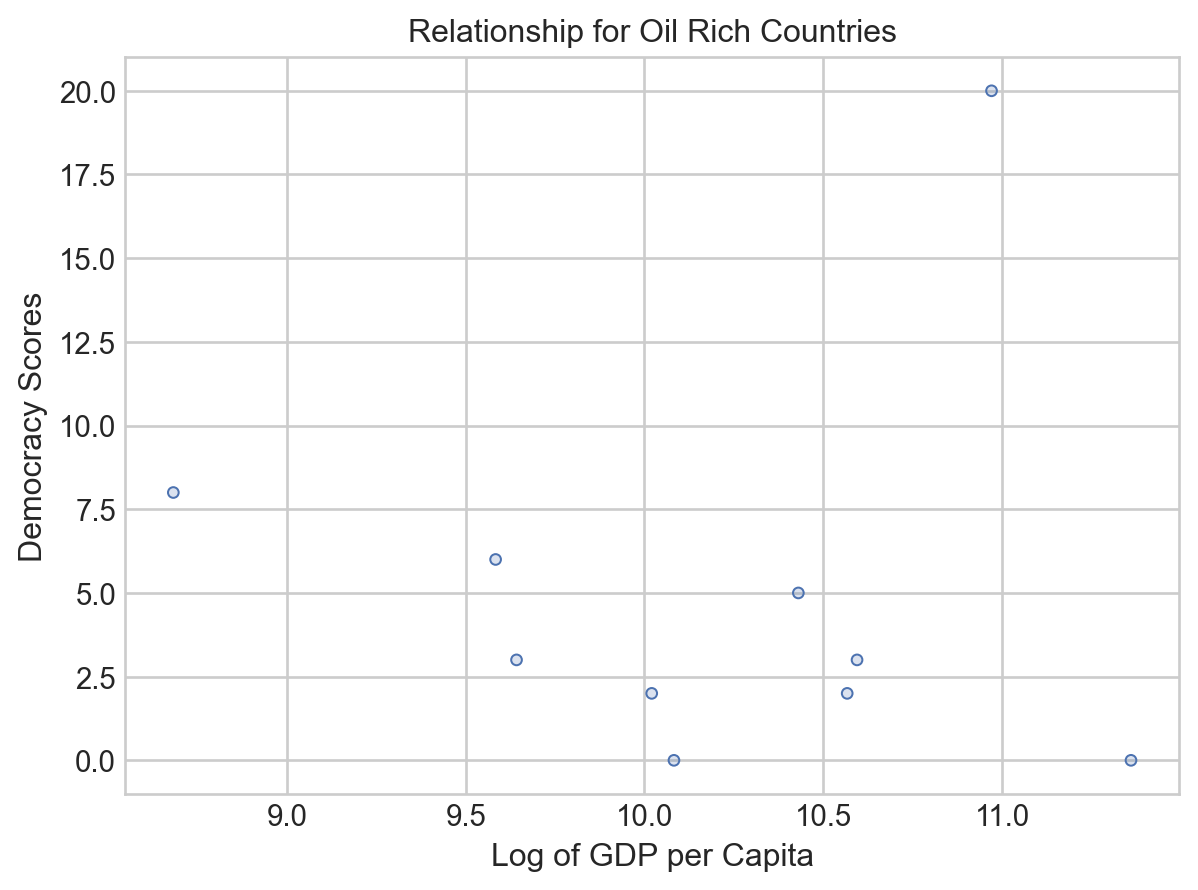

In [116]:
# only 10 oil-rich countries

oil_rich_countries = [
    "Qatar",
    "Kuwait",
    "Equatorial Guinea",
    "UAE",
    "Norway",
    "Saudi Arabia",
    "Libya",
    "Oman",
    "Gabon",
    "Angola",
]

wdi_oil_rich = wdi_log[wdi_log["country"].isin(oil_rich_countries)]
(
    so.Plot(wdi_oil_rich, x="log_gdppcap08", y="polityIV")
    .add(so.Dots())
    .add(so.Lines(), Lowess())
    .label(
        x="Log of GDP per Capita",
        y="Democracy Scores",
        title="Relationship for Oil Rich Countries",
    )
    .theme({**style.library["seaborn-v0_8-whitegrid"]})
)

### Exercise 12

Look back to your answer for Exercise 2. Do you still believe the result of your linear model? What did you learn from plotting. Write down your answers with your partner. 


<span style="color: #008080">When compared the Exercise 2 and 11, I hardly tell statistically significant relationship between ``gdppcap08`` and ``polityIV`` from the plot of Exercise 11. This underscores the importance of always visualizing our data, as it can reveal patterns that are not immediately apparent in statistical summaries alone. Some oil-producing countries might have high GDP but varying democracy scores, further convoluting any potential relationship.</span>

### Exercise 13

Finally, let's make a plot that color codes countries by whether they are big oil producers. Include separate linear regression fits for both groups.

/Users/castnut/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


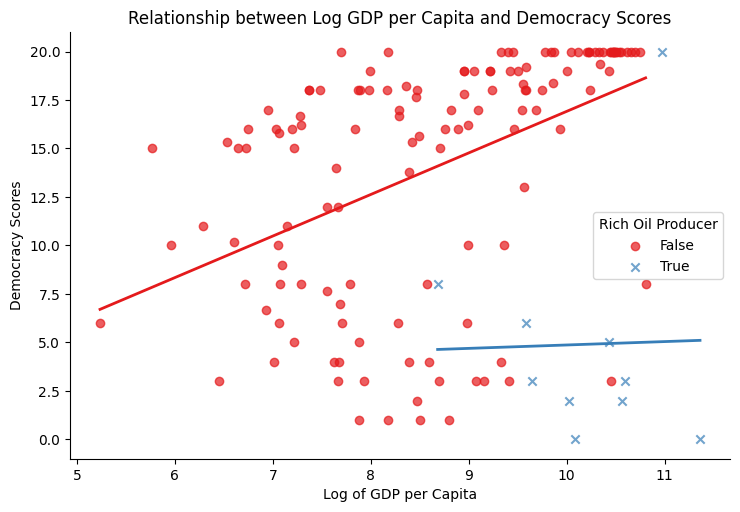

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

# just two lines
# keep the countries labels
# Creating a new column to indicate whether a country is a big oil producer
wdi_log["is_oil_producer"] = wdi_log["country"].isin(oil_rich_countries)


plot = sns.lmplot(
    data=wdi_log,
    x="log_gdppcap08",
    y="polityIV",
    hue="is_oil_producer",
    ci=None,
    markers=["o", "x"],
    palette="Set1",
    scatter_kws={"alpha": 0.7},
    line_kws={"linewidth": 2},
    aspect=1.5,
    legend=False,
)

plt.title("Relationship between Log GDP per Capita and Democracy Scores")
plt.xlabel("Log of GDP per Capita")
plt.ylabel("Democracy Scores")
handles, labels = plot.ax.get_legend_handles_labels()
plt.legend(handles, labels, title="Rich Oil Producer", loc="center right")
plt.show()

## Take-aways

One of our main jobs as data scientists is to *summarize* data. In fact, its such an obvious part of our jobs we often don't think about it very much. In reality, however, this is one of the most difficult things we do. 

Summarization means taking rich, complex data and trying to tell readers about what is going on in that data using simple statistics. In the process of summarization, therefore, we must necessarily throw away much of the richness of the original data. When done well, this simplification makes data easier to understand, but only if we throw away the *right* data. You can *always* calulate the average value of a variable, or fit a linear model, but whether doing so generates a summary statistic that properly represents the essence of the data being studied depends on the data itself. 

Plotting is one fo the best tools we have as data scientists for evaluating whether we are throwing away the *right* data. As we learned from Part 1 of this exercise, just looking at means and standard deviations can mask tremendous variation. Each of our example datasets looked the same when we examined our summary statistics, but they were all radically different when plotted. 

Similarly, a simple linear model would "tell" us that if GDP per capita increases by \$10,000, we would expect Polity scores to increase by about 1 (i.e. the coefficent on the linear model was 9.602e-05). But when we plot the data, not only can we that the data is definitely *not* linear (and so that slope doesn't really mean anything), but we can also see that oil producing countries seem to defy the overall trend, and so should maybe be studied separately. 

Moreover, we can see that if we just look at oil producers, there is no clear story: some are rich and democratic, while others are rich and autocratic (indeed, [this observation is the foundation of some great research on the political consequences of resource wealth](https://www.jstor.org/stable/41480824)!)

So remember this: tools for summarizing data will always give you an answer, but it's up to you as a data scientist to make sure that the summaries you pass on to other people properly represent the data you're using. And there is perhaps no better way to do this than with plotting!



## Overlaying Data Series with matplotlib

In our last plotting exercises, you were asked to make a paired plot in which different data series were plotted next to one another with a shared x-axis. Presumably that resulted in a figure that looked something like this:

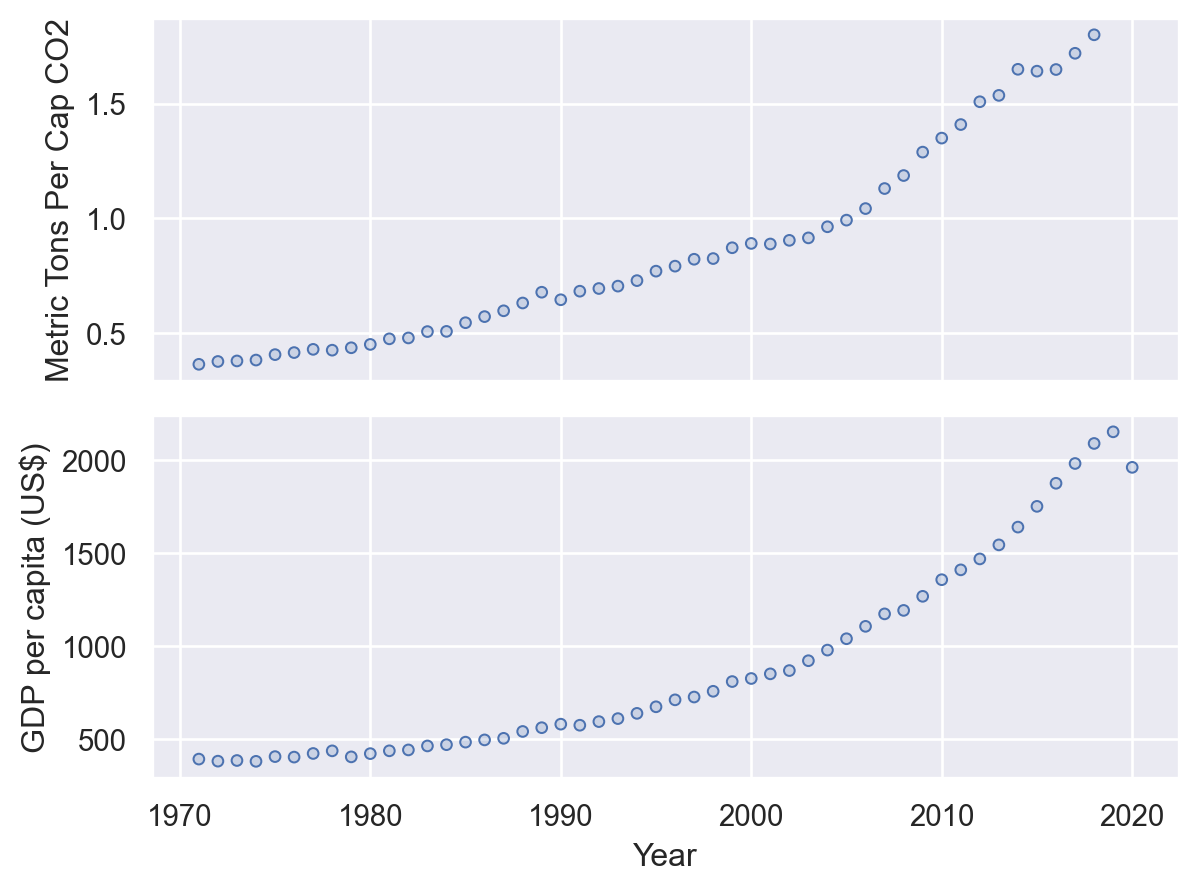

In [118]:
import pandas as pd
import numpy as np

pd.set_option("mode.copy_on_write", True)

import seaborn.objects as so
from matplotlib import style
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

wdi = pd.read_csv(
    "https://raw.githubusercontent.com/nickeubank/"
    "practicaldatascience/master/Example_Data/wdi_plotting.csv"
)

india = wdi[wdi["Country Name"] == "India"]

india = india.rename(
    columns={
        "CO2 emissions (metric tons per capita)": "Metric Tons Per Cap CO2",
        "GDP per capita (constant 2010 US$)": "GDP per capita (US$)",
    }
)
p = (
    so.Plot(
        india,
        x="Year",
    )
    .add(so.Dots())
    .pair(
        y=[
            "Metric Tons Per Cap CO2",
            "GDP per capita (US$)",
        ]
    )
)
p

Often times, however, it's more interesting to directly overlay data series on the same plot to make a figure like this:

![two series sample plot](images/two_series_overlay.png)

So let's do that here!

### Exercise 14

Making this work will require two new tricks: 

- using the `.twinx()` method from matplotlib, and 
- suing the `.on()` method from seaborn.objects.

How? Great question! I'm going to leave it to you to figure that out using the documentation for these methods. But here's a start — you can find the `.on()` [method for seaborn.objects here](https://seaborn.pydata.org/generated/seaborn.objects.Plot.on.html), and the `.twinx()` for matplotlib [method demonstrated here](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html#sphx-glr-gallery-subplots-axes-and-figures-two-scales-py)

Oh, and you may note use these two variables as your two. :) 

Good luck! 

Also, if you want to, feel free to add any extra bells and whistles as part of your exploration (like a legend, or colored y-axis labels).

In [119]:
india.columns

Index(['Year', 'Country Name', 'Country Code', 'GDP per capita (US$)',
       'Population, total', 'Metric Tons Per Cap CO2',
       'Mortality rate attributed to household and ambient air pollution, age-standardized (per 100,000 population)',
       'PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)',
       'Life expectancy at birth, total (years)',
       'Mortality rate, under-5 (per 1,000 live births)',
       'Literacy rate, youth female (% of females ages 15-24)'],
      dtype='object')

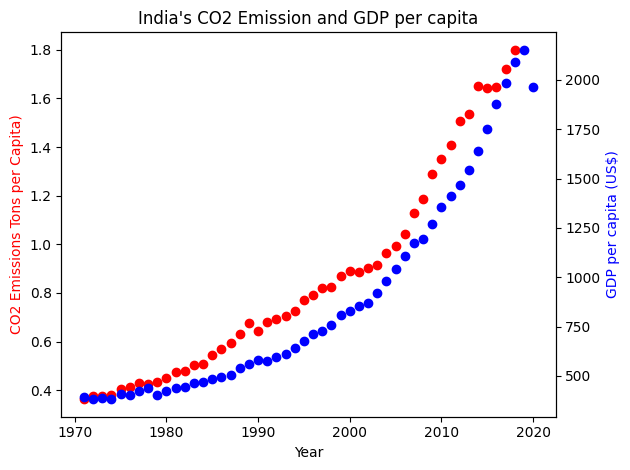

In [120]:
india = wdi[wdi["Country Name"] == "India"]

fig, ax1 = plt.subplots()
ax1.scatter(india["Year"], india["CO2 emissions (metric tons per capita)"], color="red")
ax1.set_xlabel("Year")
ax1.set_ylabel("CO2 Emissions Tons per Capita)", color="red")
ax1.set_title("India's CO2 Emission and GDP per capita")


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.scatter(india["Year"], india["GDP per capita (constant 2010 US$)"], color="blue")
ax2.set_xlabel("Year")
ax2.set_ylabel(
    "GDP per capita (US$)", color="blue"
)  # we already handled the x-label with ax1


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()